In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import TFTEstimator

/home/kashif/.env/pytorch/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
dataset = get_dataset("electricity")

In [4]:
estimator = TFTEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    num_feat_static_cat=1,
    cardinality=[321],

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', gpus=1),
)

In [5]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
GPU available: True, used: True
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/glu

Training: 0it [00:00, ?it/s]

Epoch 0, global step 99: train_loss reached 6.38547 (best 6.38547), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_38/checkpoints/epoch=0-step=99.ckpt" as top 1
Epoch 1, global step 199: train_loss reached 5.69424 (best 5.69424), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_38/checkpoints/epoch=1-step=199.ckpt" as top 1
Epoch 2, global step 299: train_loss reached 5.52260 (best 5.52260), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_38/checkpoints/epoch=2-step=299.ckpt" as top 1
Epoch 3, global step 399: train_loss reached 5.43439 (best 5.43439), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_38/checkpoints/epoch=3-step=399.ckpt" as top 1
Epoch 4, global step 499: train_loss reached 5.38715 (best 5.38715), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_38/checkpoints/epoch=4-step=499.ck

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [7]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluo

In [8]:
tss = list(ts_it)

In [9]:
evaluator = Evaluator()

In [10]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 5399.22it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq i

In [11]:
agg_metrics

{'MSE': 2288155.4595733206,
 'abs_error': 8677549.890345097,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7392301619000542,
 'MAPE': 0.0942166421951502,
 'sMAPE': 0.10727499540855988,
 'MSIS': 5.90130373159719,
 'QuantileLoss[0.1]': 3652603.570823352,
 'Coverage[0.1]': 0.09373609256786827,
 'QuantileLoss[0.2]': 5729977.868776519,
 'Coverage[0.2]': 0.21504598724224894,
 'QuantileLoss[0.3]': 7170568.846287252,
 'Coverage[0.3]': 0.342215546654799,
 'QuantileLoss[0.4]': 8147483.8875474585,
 'Coverage[0.4]': 0.46387776294318356,
 'QuantileLoss[0.5]': 8677549.828375284,
 'Coverage[0.5]': 0.5856697819314641,
 'QuantileLoss[0.6]': 8664060.21840468,
 'Coverage[0.6]': 0.6839860554813825,
 'QuantileLoss[0.7]': 8038668.19911083,
 'Coverage[0.7]': 0.7789645453196856,
 'QuantileLoss[0.8]': 6666073.66160029,
 'Coverage[0.8]': 0.8620753597389113,
 'QuantileLoss[0.9]': 4274899.861139778,
 'Coverage[0.9]': 0.9331886960391633,
 '

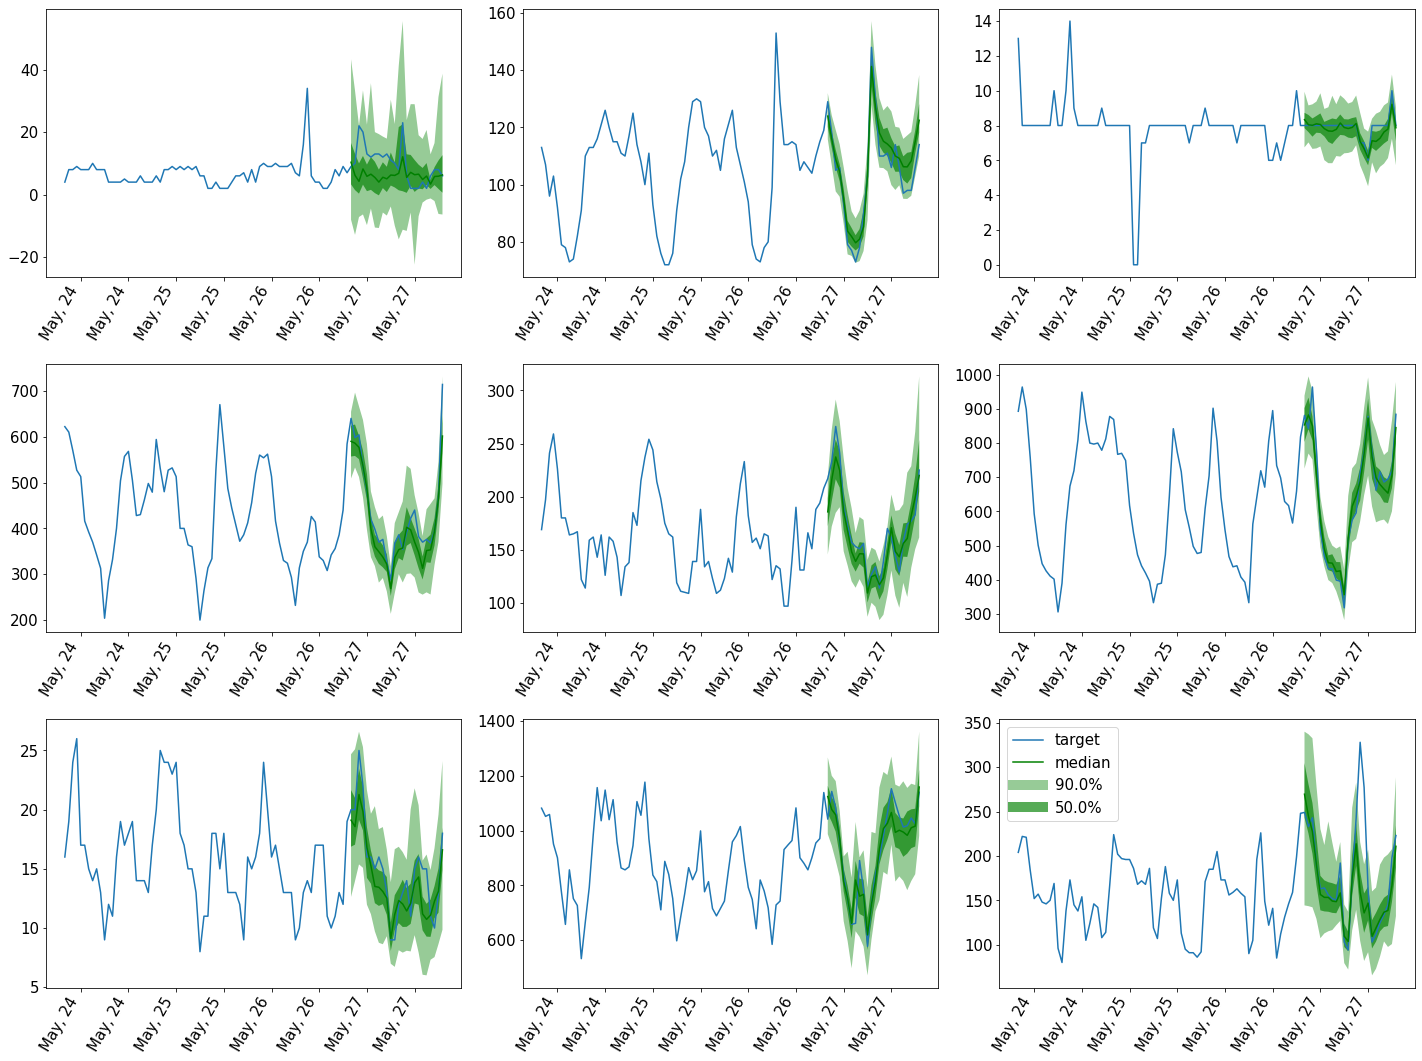

In [12]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()